### Importing Libraries

In [6]:
import cv2
import numpy as np
import imageio as iio
from matplotlib import pyplot as plt

### Loding images

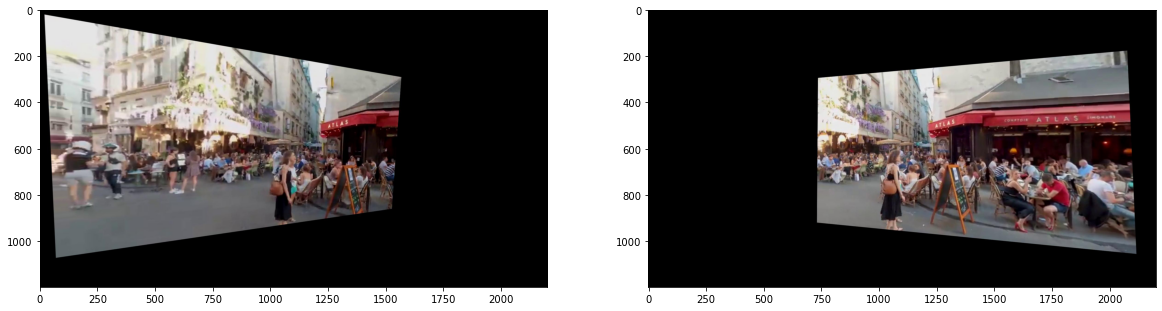

In [7]:
left = iio.imread("q2_0.jpg")
right = iio.imread("q2_1.jpg")
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(left)
plt.subplot(122)
plt.imshow(right);

#### crop both images

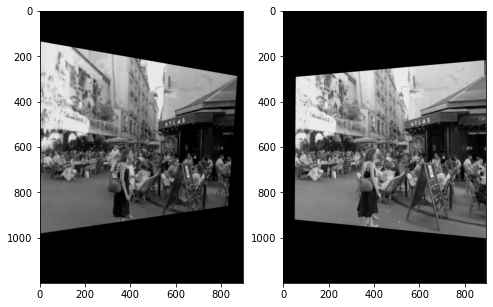

In [8]:
s = 695#755
l = 1590#1608
d = -15
#d = 0
left_croped = cv2.cvtColor(left[:,s:l], cv2.COLOR_BGR2GRAY).astype("float64")
right_croped =  cv2.cvtColor(right[:,s+d:l+d], cv2.COLOR_BGR2GRAY).astype("float64")
plt.figure(figsize=(8,10))
plt.subplot(121)
plt.imshow(left_croped.astype("uint8"),cmap="gray")
plt.subplot(122)
plt.imshow(right_croped.astype("uint8"),cmap="gray");

#### Calculation of overlap error

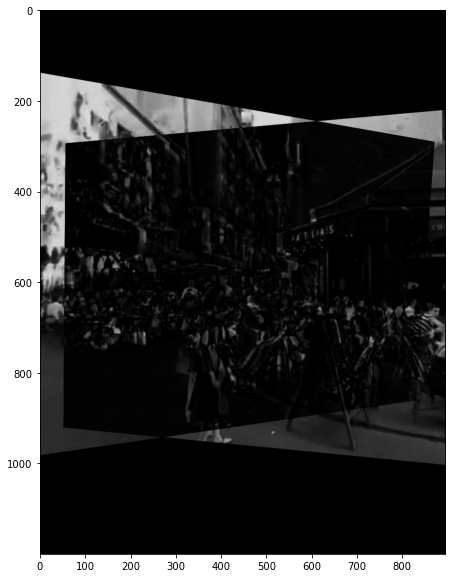

In [9]:
diff = abs(left_croped - right_croped)**2
#diff = abs(left_croped - right_croped)
plt.figure(figsize=(10,10))
plt.imshow(diff,cmap="gray");

#### Minimum error boundary cut with dynamic programming

from :
https://courses.engr.illinois.edu/cs445/fa2019/lectures/Lecture%2007%20-%20Texture%20Synthesis%20-%20CP%20Fall%202019.pdf

In [10]:
def get_min_border(img):
    m,n = img.shape
    out = np.zeros((m,n)) # path itself
    costs = np.zeros((m,n),dtype=int) # cost till the node
    last = np.zeros((m,n)) # -1, 0, 1 upper node
    for i in range(m):
        for j in range(n):
            if(i>0):
                if (j==0):
                    costs[i,j] = img[i,j]+ min(costs[i-1,j],costs[i-1,j+1])
                elif (j==n-1):
                    costs[i,j] = img[i,j]+ min(costs[i-1,j],costs[i-1,j-1])
                else:
                    k = np.argmin(costs[i-1,j-1:j+2])
                    if j+k < n-1 and costs[i-1,j-1+k] == costs[i-1,j+k]:
                        k += 1 # not important, for keeping lines vertical
                    costs[i,j] = img[i,j]+costs[i-1,j-1+k]
                    last[i,j] = k-1
    l = np.argmin(costs[m-1,:])
    out[m-1,l] = 1
    for i in range(2,m):
        k = last[m-i+1,l]
        l = int(l+k)
        out[m-i,l] = 1
    return out.astype("uint8")

In [11]:
path = get_min_border(diff)
iio.imwrite("q2/path.png",255*path)

In [12]:
mask = np.zeros(left.shape[:2])
for i in range(path.shape[0]):
    k = np.argmax(path[i,:])
    mask[i,:s+k] = 1
mask = np.dstack((mask,mask,mask)).astype("uint8")
iio.imwrite("q2/path_mask.png",255*mask)

#### Used images

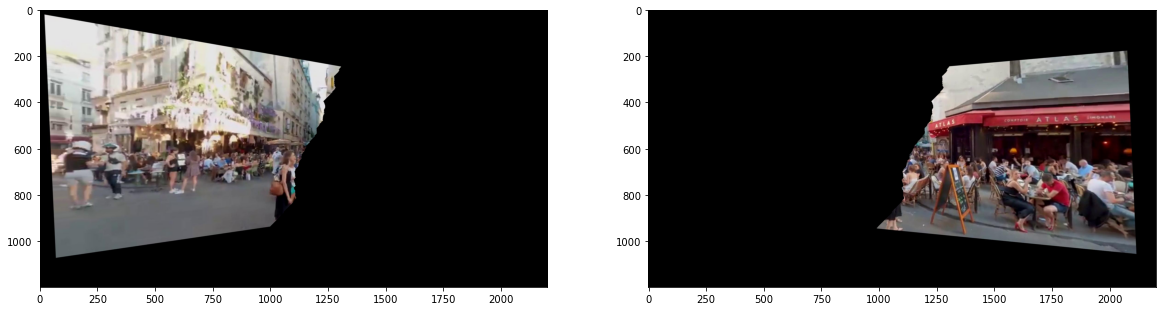

In [13]:
img1 = left*mask
img2 = right*(1-mask)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img1.astype("uint8"))
plt.subplot(122)
plt.imshow((img2).astype("uint8"));

#### Simple addition without laplassian pyramids

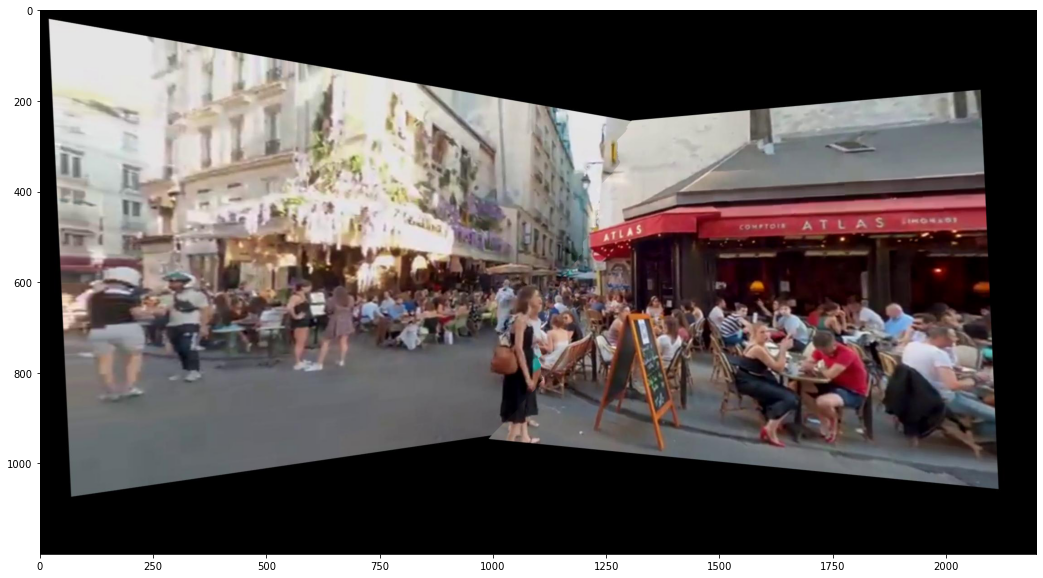

In [14]:
plt.figure(figsize=(20,10))
plt.imshow((img1+img2).astype("uint8"))
iio.imwrite("q2/res_just_adding.png",(img1+img2).astype("uint8"))

#### function for getting laplacian pyramid

which I didn't used here

In [15]:
def get_laplacian_pyramid_layer(img, n): # not used
    currImg, i = img, 0
    while i < n: # and currImg.size > max_level
        down, up = new_empty_img(img.shape), new_empty_img(img.shape)
        down = cv2.pyrDown(img)
        up = cv2.pyrUp(down, dstsize=currImg.shape)
        lap = currImg - up
        currImg = down
        i += 1
    return lap

#function for scaling images between 0 to 255
def scale(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))*255

### Laplacian Pyramids

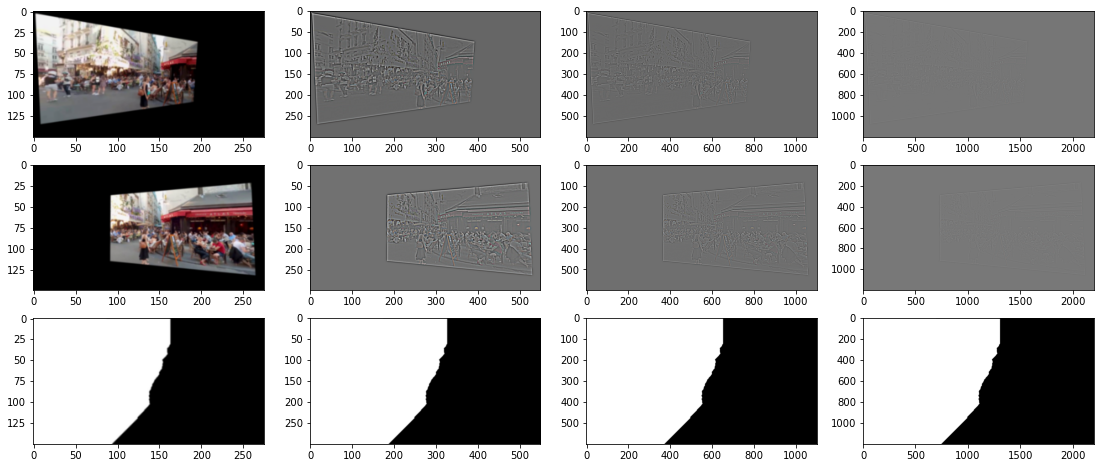

In [16]:
N = 4
# generate Gaussian pyramid for mask
G = mask.copy().astype("float64")
gpM = [G]
for i in range(N):
    G = cv2.pyrDown(G)
    gpM.append(G.astype("float64"))
    
# generate Gaussian pyramid for left
G = left.copy().astype("float64")
gpL = [G]
for i in range(N):
    G = cv2.pyrDown(G)
    gpL.append(G.astype("float64"))

# generate Gaussian pyramid for right
G = right.copy().astype("float64")
gpR = [G]
for i in range(N):
    G = cv2.pyrDown(G)
    gpR.append(G.astype("float64"))
    
# generate Laplacian Pyramid for left
lpL = [gpL[N-1]]
for i in range(N-1,0,-1):
    GE = cv2.pyrUp(gpL[i]).astype("float64")
    L = cv2.subtract(gpL[i-1],GE)
    lpL.append(L.astype("float64"))
    
# generate Laplacian Pyramid for right
lpR = [gpR[N-1]]
for i in range(N-1,0,-1):
    GE = cv2.pyrUp(gpR[i]).astype("float64")
    L = cv2.subtract(gpR[i-1],GE)
    lpR.append(L.astype("float64"))

plt.figure(figsize=(19,8))
for i in range(N):
    plt.subplot(3,N,i+1)
    plt.imshow(scale(lpL[i]).astype("uint8"))
    plt.subplot(3,N,N*(1)+i+1)
    plt.imshow(scale(lpR[i]).astype("uint8"))
    plt.subplot(3,N,N*(2)+i+1)
    plt.imshow((255*gpM[N-i-1]).astype("uint8"))

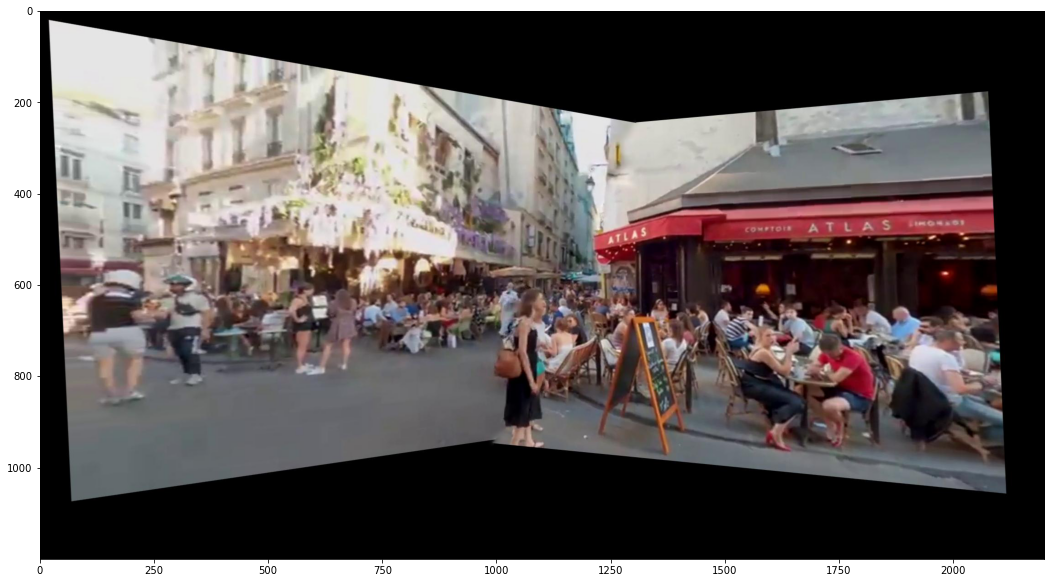

In [17]:
# Now add left and right of images in each level
LS = []
for i in range(N):
    ls = lpL[i]*gpM[N-i-1] + lpR[i]*(1-gpM[N-i-1])
    LS.append(ls.astype("float64"))
    
# now reconstruct
ls_ = LS[0].astype("float64")
for i in range(1,N):
    ls_ = cv2.pyrUp(ls_).astype("float64")
    ls_ = cv2.add(ls_, LS[i])
    
final = ls_.copy()
final[ls_<0] = 0 #removing the negetive values

plt.figure(figsize=(18,15))
plt.imshow(final.astype("uint8"))
iio.imwrite("q2/res_q2.jpg",final.astype("uint8"))